Two-dimensional toy example

The data in this example consists of two classes, one sampled from within the unit circle and the other from the ring with minimum radius 1 and maximum radius 1.41.

The classes are designed to be informative in the quadratic interactions $x_0x_0$ and $x_1x_1$, but not in the remaining interactions x_0, x_1 and x_0x_1.

In [1]:
import numpy as np
import os
import sys

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(),'..','..')))
from explainpolysvm import expsvm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


In [2]:
n_train_per_class = 500  # We will later remove 25 samples per class to a test set.

# Radii for rings
r_min1 = 0.
r_max1 = 1.05
r_min2 = 0.95
r_max2 = 1.41
z_min = -2
z_max = 2

# Sample from classes
phi_train1 = 2 * np.pi * np.random.rand(n_train_per_class)
r_train1 = r_min1 + (r_max1 - r_min1) * np.random.rand(n_train_per_class, 1)
z_train1 = z_min + (z_max-z_min)*np.random.rand(n_train_per_class,1)
X_train1 = np.concatenate((np.multiply(r_train1, np.transpose(np.array((np.cos(phi_train1), np.sin(phi_train1))))),z_train1),axis=1)

phi_train2 = 2 * np.pi * np.random.rand(n_train_per_class)
r_train2 = r_min2 + (r_max2 - r_min2) * np.random.rand(n_train_per_class, 1)
z_train2 = z_min + (z_max-z_min)*np.random.rand(n_train_per_class,1)
X_train2 = np.concatenate((np.multiply(r_train2, np.transpose(np.array((np.cos(phi_train2), np.sin(phi_train2))))),z_train2),axis=1)


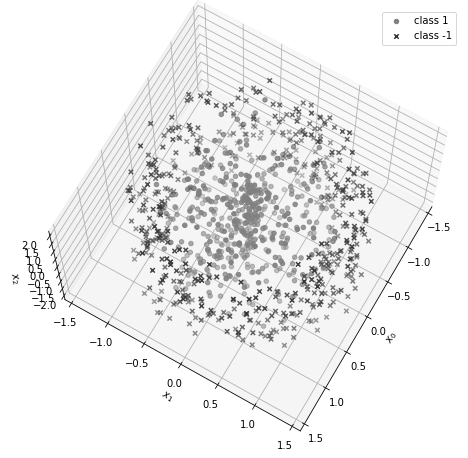

In [3]:
# fig, ax = plt.subplots(1,1, figsize=(5,5))
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train1[:,0], X_train1[:,1], X_train1[:,2], color=[0.5, 0.5, 0.5])
ax.scatter(X_train2[:,0], X_train2[:,1], X_train2[:,2], color=[0.2, 0.2, 0.2], marker='x')
# ax.set_aspect('equal', adjustable='box')
plt.legend(['class 1', 'class -1'])
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$x_2$')
ax.view_init(70,30)

plt.savefig('./training_data_3d.png', dpi=300, facecolor='white')
plt.draw()

Fit Scikit-learn SVC model using a quadratic polynomial kernel and manually set hyperparameters.

In [4]:
X = np.concatenate((X_train1, X_train2), axis=0)
y = np.concatenate((np.ones(n_train_per_class), -np.ones(n_train_per_class)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=600, random_state=10)
# Fit SVM
C = 0.9
degree = 3
gamma = 'scale'
r = np.sqrt(2)

# Fit SVM
kernel = 'poly'
model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, coef0=r)
model.fit(X_train, y_train)

sv = model.support_vectors_
dual_coef = np.squeeze(model.dual_coef_)
intercept = model.intercept_[0]
kernel_gamma = model._gamma

es = expsvm.ExPSVM(sv=sv, dual_coef=dual_coef, intercept=intercept,
                kernel_d=degree, kernel_r=r, kernel_gamma=kernel_gamma)
es.transform_svm()

Test performance

In [5]:
y_pred = np.sign(es.decision_function(x=X_test))
acc = np.sum(y_pred==y_test)/y_test.size
print('Test accuracy: {}'.format(acc))

Test accuracy: 0.935


Feature importance

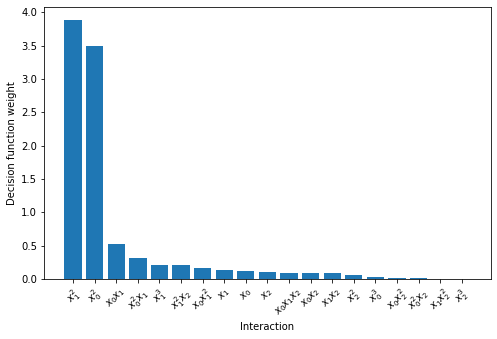

In [6]:
feat_importance, feat_names, sort_order = es.feature_importance(format_names=True)

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.bar(x=np.arange(feat_importance.size), height=feat_importance, tick_label=['${}$'.format(name) for name in feat_names])
plt.xticks(rotation=45)
plt.xlabel('Interaction')
plt.ylabel('Decision function weight')
plt.savefig('./feature_importance_3d.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.draw()

The two expected interactions, $x_0x_0$ and $x_1x_1$, clearly stands out as the two most important.

Evaluate performance using the top-2 features

In [7]:
es.set_mask(n_interactions=2)
# es.force_mask=True
y_pred_masked = np.sign(es.decision_function(x=X_test, mask=True))
acc_masked = np.sum(y_pred_masked==y_test)/y_test.size
print('Test accuracy using top-2 interactions: {}'.format(acc_masked))

Test accuracy using top-2 interactions: 0.945
